In [54]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 22 07:05:30 2017

@author: angusurquhart
Extract meta data from trackobot
"""
from collections import defaultdict
import trackopy
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as pl
import numpy as np
from sqlalchemy import create_engine
from sklearn.linear_model import LogisticRegression
import random

In [55]:
#Setup trackobot
user = {"password":'e479deb2e1', 'username':'still-gnoll-6604'}
trackobot = trackopy.Trackobot(user['username'], user['password'])

In [56]:
#trackobot.history(page=7)

In [131]:
#Put all the pages into a single dictionary
#Note that this is game level data - 'history'
singledict = {}
list_of_game_dicts = []

for x in range(1,18):

     singledict[1] = trackobot.history(page=x)
     list_of_game_dicts.append(singledict.copy())
    
#list_of_game_dicts

In [132]:
#this shows that i can access a single page
#I'll come back to this and loop over it once I have my output ready
page = list_of_game_dicts[5]
page
#page

{1: {'history': [{'added': '2017-05-24T06:38:27.000Z',
    'card_history': [],
    'coin': False,
    'duration': 1028,
    'hero': 'Warlock',
    'hero_deck': None,
    'id': 78431012,
    'legend': None,
    'mode': 'ranked',
    'note': None,
    'opponent': 'Priest',
    'opponent_deck': None,
    'rank': None,
    'result': 'win'},
   {'added': '2017-05-23T18:45:16.000Z',
    'card_history': [],
    'coin': True,
    'duration': 787,
    'hero': 'Priest',
    'hero_deck': 'Dragon',
    'id': 78372077,
    'legend': None,
    'mode': 'ranked',
    'note': None,
    'opponent': 'Mage',
    'opponent_deck': 'Burn',
    'rank': None,
    'result': 'win'},
   {'added': '2017-05-23T18:31:39.000Z',
    'card_history': [],
    'coin': False,
    'duration': 424,
    'hero': 'Priest',
    'hero_deck': 'Dragon',
    'id': 78370279,
    'legend': None,
    'mode': 'ranked',
    'note': None,
    'opponent': 'Warlock',
    'opponent_deck': None,
    'rank': None,
    'result': 'loss'},
   {'a

In [115]:
#this shows the level at which useful data is containted
#the meta stuff in this case is pretty useless - the real info is in the history.
page[1].keys()

dict_keys(['meta', 'history'])

In [114]:
#This is actually the data we'll want to flatten into a table
page[1]['history']

[{'added': '2017-06-12T06:49:07.000Z',
  'card_history': [{'card': {'id': 'UNG_934',
     'mana': 1,
     'name': "Fire Plume's Heart"},
    'player': 'me',
    'turn': 1},
   {'card': {'id': 'UNG_934', 'mana': 1, 'name': "Fire Plume's Heart"},
    'player': 'opponent',
    'turn': 1},
   {'card': {'id': 'KAR_011', 'mana': 2, 'name': 'Pompous Thespian'},
    'player': 'me',
    'turn': 2},
   {'card': {'id': 'GAME_005', 'mana': 0, 'name': 'The Coin'},
    'player': 'opponent',
    'turn': 2},
   {'card': {'id': 'UNG_928', 'mana': 3, 'name': 'Tar Creeper'},
    'player': 'opponent',
    'turn': 2},
   {'card': {'id': 'UNG_072', 'mana': 3, 'name': 'Stonehill Defender'},
    'player': 'me',
    'turn': 3},
   {'card': {'id': 'EX1_606', 'mana': 3, 'name': 'Shield Block'},
    'player': 'opponent',
    'turn': 3},
   {'card': {'id': 'CS2_106', 'mana': 2, 'name': 'Fiery War Axe'},
    'player': 'me',
    'turn': 4},
   {'card': {'id': 'CS2_102', 'mana': 2, 'name': 'Armor Up!'},
    'player':

In [110]:
#This is digging into the card 
page[1]['history'][0]['card_history'][-1]['turn']

12

In [9]:
#This is the id for a single game
page[1]['history'][0]['id']

80739823

In [10]:
#Build a dataframe of page 1 meta info
df = pd.DataFrame(page[1]['history'], columns=['added','coin', 'duration','hero','hero_deck','id','legend','mode','note','opponent','opponent_deck','rank','result'])
df.head()

,added,coin,duration,hero,hero_deck,id,legend,mode,note,opponent,opponent_deck,rank,result
0,2017-06-12T06:49:07.000Z,False,599,Warrior,Taunt,80739823,NaN,ranked,None,Warrior,Taunt,NaN,win
1,2017-06-12T06:34:17.000Z,True,182,Warrior,Pirate,80739150,NaN,ranked,None,Hunter,Midrange,NaN,loss
2,2017-06-11T20:30:26.000Z,False,233,Paladin,None,80706030,NaN,ranked,None,Hunter,Midrange,NaN,win
3,2017-06-11T20:26:25.000Z,False,386,Paladin,Murloc,80705648,NaN,ranked,None,Hunter,Midrange,NaN,loss
4,2017-06-11T20:15:04.000Z,True,397,Paladin,Murloc,80704555,NaN,ranked,None,Hunter,Midrange,18,loss


In [33]:
#Create an empty dataframe for all the meta game fields
#TO REFRESH THE DATATABLE START HERE
columns = ['added','coin', 'duration','hero','hero_deck','id','legend','mode','note','opponent','opponent_deck','rank','result','card_history']
metatable = pd.DataFrame(columns=columns)
#metatable
metatable.shape

(0, 14)

In [109]:
#I want to figure out how to apply a card level bit of data onto my meta row data
list_of_game_dicts[0][1]['history']

[{'added': '2017-05-24T06:38:27.000Z',
  'card_history': [],
  'coin': False,
  'duration': 1028,
  'hero': 'Warlock',
  'hero_deck': None,
  'id': 78431012,
  'legend': None,
  'mode': 'ranked',
  'note': None,
  'opponent': 'Priest',
  'opponent_deck': None,
  'rank': None,
  'result': 'win'},
 {'added': '2017-05-23T18:45:16.000Z',
  'card_history': [],
  'coin': True,
  'duration': 787,
  'hero': 'Priest',
  'hero_deck': 'Dragon',
  'id': 78372077,
  'legend': None,
  'mode': 'ranked',
  'note': None,
  'opponent': 'Mage',
  'opponent_deck': 'Burn',
  'rank': None,
  'result': 'win'},
 {'added': '2017-05-23T18:31:39.000Z',
  'card_history': [],
  'coin': False,
  'duration': 424,
  'hero': 'Priest',
  'hero_deck': 'Dragon',
  'id': 78370279,
  'legend': None,
  'mode': 'ranked',
  'note': None,
  'opponent': 'Warlock',
  'opponent_deck': None,
  'rank': None,
  'result': 'loss'},
 {'added': '2017-05-23T06:14:57.000Z',
  'card_history': [],
  'coin': True,
  'duration': 719,
  'hero'

In [35]:
#This will now loop through and create my meta table
for i in range(len(list_of_game_dicts)):
    metatable = metatable.append(pd.DataFrame(list_of_game_dicts[i][1]['history'], columns=['added','coin', 'duration','hero',
                                                                                        'hero_deck','id','legend','mode','note',
                                                                                        'opponent','opponent_deck','rank','result'
                                                                                           ,'card_history']
                                         ),ignore_index = True)

metatable.shape


(105, 14)

In [74]:
#metatable.dtypes
#state the name of the first card in the first game
metatable['card_history'][0][0]['card']['name']

"Fire Plume's Heart"

In [98]:
#Looping through my list of cards - for some reason we only have 47
#for i in range(len(metatable['card_history'])):
elements = []
#columns2 = ['name']
#testy = pd.DataFrame(columns=columns2)
for i in range(0, 47):
    elements.append(metatable['card_history'][i][0]['card']['name'])
    #testy = testy.append(pd.DataFrame(metatable['card_history'][10][0]['card']['name'], columns=['name']),ignore_index = True)
elements

["Fire Plume's Heart",
 'Jeweled Macaw',
 'Grimscale Chum',
 'Jeweled Macaw',
 'Grimscale Oracle',
 "N'Zoth's First Mate",
 "Fire Plume's Heart",
 'Alleycat',
 "Fire Plume's Heart",
 'The Caverns Below',
 'Vilefin Inquisitor',
 'The Coin',
 'Jeweled Macaw',
 'The Coin',
 'Mana Wyrm',
 "Fire Plume's Heart",
 'The Coin',
 'Fiery Bat',
 'Hallucination',
 'Jade Idol',
 'Hallucination',
 'Grimscale Oracle',
 'Awaken the Makers',
 'Alleycat',
 'Jeweled Macaw',
 'Alleycat',
 'Jeweled Macaw',
 'Glacial Shard',
 'Babbling Book',
 'Arcanologist',
 'Twilight Whelp',
 'Northshire Cleric',
 'Glacial Shard',
 'Jade Claws',
 'Totemic Call',
 'Northshire Cleric',
 'The Caverns Below',
 'Netherspite Historian',
 'The Coin',
 'Vilefin Inquisitor',
 'Vilefin Inquisitor',
 'Open the Waygate',
 'Mana Wyrm',
 'Crystalline Oracle',
 'Mind Vision',
 'Grimscale Oracle',
 'The Coin']

In [106]:
metatable

,added,coin,duration,hero,hero_deck,id,legend,mode,note,opponent,opponent_deck,rank,result,card_history
0,2017-06-12T06:49:07.000Z,False,599,Warrior,Taunt,80739823,NaN,ranked,None,Warrior,Taunt,NaN,win,"[{'player': 'me', 'card': {'name': 'Fire Plume..."
1,2017-06-12T06:34:17.000Z,True,182,Warrior,Pirate,80739150,NaN,ranked,None,Hunter,Midrange,NaN,loss,"[{'player': 'opponent', 'card': {'name': 'Jewe..."
2,2017-06-11T20:30:26.000Z,False,233,Paladin,None,80706030,NaN,ranked,None,Hunter,Midrange,NaN,win,"[{'player': 'me', 'card': {'name': 'Grimscale ..."
3,2017-06-11T20:26:25.000Z,False,386,Paladin,Murloc,80705648,NaN,ranked,None,Hunter,Midrange,NaN,loss,"[{'player': 'opponent', 'card': {'name': 'Jewe..."
4,2017-06-11T20:15:04.000Z,True,397,Paladin,Murloc,80704555,NaN,ranked,None,Hunter,Midrange,18,loss,"[{'player': 'me', 'card': {'name': 'Grimscale ..."
5,2017-06-11T20:08:18.000Z,True,310,Paladin,None,80703899,NaN,ranked,None,Warrior,Pirate,18,loss,"[{'player': 'opponent', 'card': {'name': 'N'Zo..."
6,2017-06-11T20:02:36.000Z,False,206,Warrior,None,80703319,NaN,ranked,None,Mage,None,18,loss,"[{'player': 'me', 'card': {'name': 'Fire Plume..."
7,2017-06-11T19:58:52.000Z,True,235,Warrior,Taunt,80702952,NaN,ranked,None,Hunter,Midrange,18,loss,"[{'player': 'opponent', 'card': {'name': 'Alle..."
8,2017-06-11T19:54:45.000Z,False,578,Warrior,Taunt,80702527,NaN,ranked,None,Warrior,Pirate,18,win,"[{'player': 'me', 'card': {'name': 'Fire Plume..."
9,2017-06-11T19:44:52.000Z,False,379,Paladin,Murloc,80701594,NaN,ranked,None,Rogue,Quest,18,win,"[{'player': 'opponent', 'card': {'name': 'The ..."


In [20]:
#I want to do some pre-work to tidy up fields for an import into sql
#Alytic doesn't like true false fields so change to text
metatable['coin'] = metatable['coin'].replace(True,'Go First')
metatable['coin'] = metatable['coin'].replace(False,'Go Second')

#I want a field for wins and losses so that I can do wins as a % of total
dummy_result = pd.get_dummies(metatable['result'], prefix='result')
#dummy_result.head()
metatable = pd.concat([metatable, dummy_result], axis=1)



#Add some fields for counting games
metatable['Game Counter/100'] = 0.01
metatable['Game Counter'] = 1

#Convert added field to be DateTime
metatable['DateTime'] = pd.to_datetime(metatable['added'],exact = False)

#Now create useful date fields
metatable['Date'] = metatable['DateTime'].dt.date
metatable['Time'] = metatable['DateTime'].dt.time
metatable['Month'] = metatable['DateTime'].apply(lambda x: x.strftime('%B-%Y'))   

#Drop useless columns
metatable = metatable.drop('legend', 1)
metatable = metatable.drop('note', 1)
metatable = metatable.drop('added', 1)

#Rename some fields, in particular, rank which is used for other commands
metatable = metatable.rename(columns={'rank': 'H_rank'})

metatable.head()
#metatable.dtypes
                       

,coin,duration,hero,hero_deck,id,mode,opponent,opponent_deck,H_rank,result,result_loss,result_win,Game Counter/100,Game Counter,DateTime,Date,Time,Month
0,Go Second,599,Warrior,Taunt,80739823,ranked,Warrior,Taunt,NaN,win,0,1,0.01,1,2017-06-12 06:49:07,2017-06-12,06:49:07,June-2017
1,Go First,182,Warrior,Pirate,80739150,ranked,Hunter,Midrange,NaN,loss,1,0,0.01,1,2017-06-12 06:34:17,2017-06-12,06:34:17,June-2017
2,Go Second,233,Paladin,None,80706030,ranked,Hunter,Midrange,NaN,win,0,1,0.01,1,2017-06-11 20:30:26,2017-06-11,20:30:26,June-2017
3,Go Second,386,Paladin,Murloc,80705648,ranked,Hunter,Midrange,NaN,loss,1,0,0.01,1,2017-06-11 20:26:25,2017-06-11,20:26:25,June-2017
4,Go First,397,Paladin,Murloc,80704555,ranked,Hunter,Midrange,18,loss,1,0,0.01,1,2017-06-11 20:15:04,2017-06-11,20:15:04,June-2017


In [36]:
metatable.head()
metatable[]

,added,coin,duration,hero,hero_deck,id,legend,mode,note,opponent,opponent_deck,rank,result,card_history
0,2017-06-12T06:49:07.000Z,False,599,Warrior,Taunt,80739823,NaN,ranked,None,Warrior,Taunt,NaN,win,"[{'player': 'me', 'card': {'name': 'Fire Plume..."
1,2017-06-12T06:34:17.000Z,True,182,Warrior,Pirate,80739150,NaN,ranked,None,Hunter,Midrange,NaN,loss,"[{'player': 'opponent', 'card': {'name': 'Jewe..."
2,2017-06-11T20:30:26.000Z,False,233,Paladin,None,80706030,NaN,ranked,None,Hunter,Midrange,NaN,win,"[{'player': 'me', 'card': {'name': 'Grimscale ..."
3,2017-06-11T20:26:25.000Z,False,386,Paladin,Murloc,80705648,NaN,ranked,None,Hunter,Midrange,NaN,loss,"[{'player': 'opponent', 'card': {'name': 'Jewe..."
4,2017-06-11T20:15:04.000Z,True,397,Paladin,Murloc,80704555,NaN,ranked,None,Hunter,Midrange,18,loss,"[{'player': 'me', 'card': {'name': 'Grimscale ..."


In [21]:
#USE THIS TO TEST NEW FIELDS TO ADD TO SQL TABLE
#Split up Un'Goro from MSOG
# Set Un-Goro release date
ungoro_date = pd.to_datetime('04-06-2017')
metatable['Expansion'] = np.where(metatable['DateTime']>ungoro_date, 'Un-Goro', 'MSOG')
#metatable[['Expansion','Date','DateTime']]

,Expansion,Date,DateTime
0,Un-Goro,2017-06-12,2017-06-12 06:49:07
1,Un-Goro,2017-06-12,2017-06-12 06:34:17
2,Un-Goro,2017-06-11,2017-06-11 20:30:26
3,Un-Goro,2017-06-11,2017-06-11 20:26:25
4,Un-Goro,2017-06-11,2017-06-11 20:15:04
5,Un-Goro,2017-06-11,2017-06-11 20:08:18
6,Un-Goro,2017-06-11,2017-06-11 20:02:36
7,Un-Goro,2017-06-11,2017-06-11 19:58:52
8,Un-Goro,2017-06-11,2017-06-11 19:54:45
9,Un-Goro,2017-06-11,2017-06-11 19:44:52


In [22]:
#I'm not going to add some predictions from a logistic regression model
#First start by formatting fields for modelling

metatable['coin_model'] = metatable['coin']
metatable['result_model'] = metatable['result']

metatable['coin_model'] = metatable['coin_model'].replace('Go First',1)
metatable['coin_model'] = metatable['coin_model'].replace('Go Second',0)
#convert the wins and losses to 1 and 0
metatable['result_model'] = metatable['result_model'].replace('loss', 0)
metatable['result_model'] = metatable['result_model'].replace('win', 1)

# i now need to turn categorical fields into crosstabs
# dummify hero
dummy_hero = pd.get_dummies(metatable['hero'], prefix='hero')
metatable = pd.concat([metatable, dummy_hero], axis=1)
metatable.head()

,coin,duration,hero,hero_deck,id,mode,opponent,opponent_deck,H_rank,result,...,result_model,hero_Druid,hero_Hunter,hero_Mage,hero_Paladin,hero_Priest,hero_Rogue,hero_Shaman,hero_Warlock,hero_Warrior
0,Go Second,599,Warrior,Taunt,80739823,ranked,Warrior,Taunt,NaN,win,...,1,0,0,0,0,0,0,0,0,1
1,Go First,182,Warrior,Pirate,80739150,ranked,Hunter,Midrange,NaN,loss,...,0,0,0,0,0,0,0,0,0,1
2,Go Second,233,Paladin,None,80706030,ranked,Hunter,Midrange,NaN,win,...,1,0,0,0,1,0,0,0,0,0
3,Go Second,386,Paladin,Murloc,80705648,ranked,Hunter,Midrange,NaN,loss,...,0,0,0,0,1,0,0,0,0,0
4,Go First,397,Paladin,Murloc,80704555,ranked,Hunter,Midrange,18,loss,...,0,0,0,0,1,0,0,0,0,0


In [23]:
#DO  LOGISTIC REGRESSION USING SKLEARN
logreg = LogisticRegression(C=1e9)
feature_cols = ['coin_model', 'duration','hero_Hunter', 'hero_Mage', 'hero_Paladin','hero_Priest','hero_Shaman','hero_Warlock',
               'hero_Warrior']
X = metatable[feature_cols]
y = metatable.result_model
logreg.fit(X, y)
metatable['Predicted Result'] = logreg.predict(X)
metatable['Probability of Winning'] = logreg.predict_proba(X)[:, 1]

#Tidy up the predicted result for transferring to sql
metatable['Predicted Result'] = metatable['Predicted Result'].replace(1, 'Predict Win')
metatable['Predicted Result'] = metatable['Predicted Result'].replace(0,'Predict Loss')

metatable["Result and Prediction"] = metatable["Predicted Result"].map(str) +' - '+ metatable["result"]
metatable.head()

,coin,duration,hero,hero_deck,id,mode,opponent,opponent_deck,H_rank,result,...,hero_Mage,hero_Paladin,hero_Priest,hero_Rogue,hero_Shaman,hero_Warlock,hero_Warrior,Predicted Result,Probability of Winning,Result and Prediction
0,Go Second,599,Warrior,Taunt,80739823,ranked,Warrior,Taunt,NaN,win,...,0,0,0,0,0,0,1,Predict Loss,0.356754,Predict Loss - win
1,Go First,182,Warrior,Pirate,80739150,ranked,Hunter,Midrange,NaN,loss,...,0,0,0,0,0,0,1,Predict Loss,0.268749,Predict Loss - loss
2,Go Second,233,Paladin,None,80706030,ranked,Hunter,Midrange,NaN,win,...,0,1,0,0,0,0,0,Predict Win,0.675648,Predict Win - win
3,Go Second,386,Paladin,Murloc,80705648,ranked,Hunter,Midrange,NaN,loss,...,0,1,0,0,0,0,0,Predict Win,0.654887,Predict Win - loss
4,Go First,397,Paladin,Murloc,80704555,ranked,Hunter,Midrange,18,loss,...,0,1,0,0,0,0,0,Predict Loss,0.492057,Predict Loss - loss


In [24]:
#At this stage I'd actually like to write my data to sql
conn_string = "mssql+pymssql://" + '192.168.1.52' + "/" + 'naturex'
engine = create_engine(conn_string)
conn = engine.connect()
metatable.to_sql('HS_MetaTable', engine, if_exists='replace', index=False, schema='dbo')


In [ ]:
#Now i want to look at my wins vs. my losses
#totalresults = metatable.groupby(['result'])['id'].agg(['count'])
#colors = ['red','green']
#totalresults.plot.bar(color = colors)

In [ ]:
#Also which heros have i been using and what are my win losses:
#wins_by_hero = metatable.groupby(['hero','result'])['id'].agg(['count'])
#bar_width = 0.35
#wins_by_hero.plot.bar()
#wins_by_hero.plot.bar(color = colors)

In [ ]:
#describe gets you some summary stats of metrics.  We don' actually have many metrics 
#in this data so it doesn't work as well.
metatable.describe()

In [ ]:
# plot all of the columns
metatable.hist()
pl.show()

In [41]:
#I also want to create a training dataset
#I ACTUALLY DON'T THINK THIS IS IMPORTANT FOR LOGISTIC REGRESSION SO WILL PROBABLY NOT BE USED
#model_base = model_base.sample(frac=1)
#train_data = model_base[:int((len(model_base)+1)*.80)] #Remaining 80% to training set
#test_data = model_base[int(len(model_base)*.80+1):] #Splits 20% data to test set

In [46]:
# store the predicted probabilites of class 1
#model_base['Probability of Winning'] = logreg.predict_proba(X)[:, 1]
#model_base

,coin,duration,hero,hero_deck,id,mode,opponent,opponent_deck,H_rank,result,result_loss,result_win,Game Counter/100,Game Counter,DateTime,Date,Time,Month,result_pred_class,Probability of Winning
82,0,351,Warrior,None,67348996,casual,Warlock,Zoo,NaN,0,1,0,0.01,1,2017-03-15 07:45:16,2017-03-15,07:45:16,March-2017,1,0.516486
35,0,258,Paladin,Aggro,78924908,ranked,Paladin,Murloc,NaN,1,0,1,0.01,1,2017-05-28 07:30:56,2017-05-28,07:30:56,May-2017,1,0.527083
68,0,356,Priest,None,77964656,casual,Druid,None,NaN,0,1,0,0.01,1,2017-05-20 18:31:05,2017-05-20,18:31:05,May-2017,1,0.515916
81,0,487,Warrior,None,67349455,casual,Rogue,Miracle,NaN,1,0,1,0.01,1,2017-03-15 07:53:34,2017-03-15,07:53:34,March-2017,1,0.500965
9,1,614,Priest,Dragon,79956734,ranked,Rogue,Quest,18,0,1,0,0.01,1,2017-06-05 06:24:49,2017-06-05,06:24:49,June-2017,0,0.459735
18,0,723,Paladin,Murloc,79632666,ranked,Shaman,None,NaN,0,1,0,0.01,1,2017-06-02 17:33:41,2017-06-02,17:33:41,June-2017,0,0.474044
99,0,186,Warlock,None,67000859,ranked,Warrior,Pirate,NaN,0,1,0,0.01,1,2017-03-12 17:58:20,2017-03-12,17:58:20,March-2017,1,0.535271
46,1,386,Priest,None,78551811,ranked,Priest,Miracle,18,0,1,0,0.01,1,2017-05-25 06:41:06,2017-05-25,06:41:06,May-2017,0,0.485682
31,0,428,Paladin,None,79049272,ranked,Hunter,Midrange,NaN,0,1,0,0.01,1,2017-05-29 06:54:08,2017-05-29,06:54:08,May-2017,1,0.507700
88,1,583,Priest,None,67156421,casual,Warlock,None,NaN,0,1,0,0.01,1,2017-03-13 20:29:26,2017-03-13,20:29:26,March-2017,0,0.463253


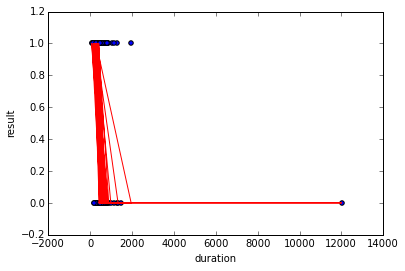

In [30]:
# plot the class predictions
plt.scatter(model_base.duration, model_base.result)
plt.plot(model_base.duration, model_base.result_pred_class, color='red')
plt.xlabel('duration')
plt.ylabel('result')

In [23]:
# manually add the intercept
#add a constant term for our Logistic Regression. 
#The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.
meta_log_reg['intercept'] = 1.0